In [2]:
from psg import PSG
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import pandas as pd
import constants
from ecg import ECG
from emg import EMG
import eeg
from eeg import EEG
from eog import EOG
from sao2 import *
from matplotlib import pyplot as plt
from scipy import stats
import gc
import sklearn as sk
from sklearn import impute as skImpute
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics

In [2]:
training_set_1 = ['ins2', 'ins6', 'n11', 'n2']
training_set_2 = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15']
training_set_3 = ['plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6']
training_set_4 = ['rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']

testing_set_1 = ['ins8', 'ins9', 'n5'] 
testing_set_2 = ['nfle16', 'nfle17', 'nfle18', 'nfle19'] 
testing_set_3 = ['plm7', 'plm8', 'plm9']
testing_set_4 = ['rbd18', 'rbd19', 'rbd20']

# Make sure you have the edf and txt files for each individual along with the GitHub modules.

for i in training_set_2:
    psg_data = PSG(i)

    #EEG Feature Extraction
    reload(eeg)
    EEG_columns = eeg.EEG(psg_data.data)
    EEG_columns.extract_features()
    eeg_data = EEG_columns.eeg_features

    #SAO2 Feature Extraction
    oxyData = psg_data.data[['epoch','SAO2']]
    sao2_data = SAO2(oxyData).get_SAO2_metrics()

    #EOG Feature Extraction
    eog_data = EOG(psg_data.data).get_EOG_metrics()

    #EMG Feature Extraction
    sxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "SX1-SX2"]]
    sx = EMG(sxDfInput, signalType = "SX1-SX2")
    sx_data = sx.getMetrics()

    dxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "DX1-DX2"]]
    dx = EMG(dxDfInput, signalType = "DX1-DX2")
    dx_data = dx.getMetrics()

    emgDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "EMG1-EMG2"]]
    emg_columns = EMG(emgDfInput)
    emg_data = emg_columns.getMetrics()

    #ECG Feature Extraction
    ecgDfInput = psg_data.data.loc[:, ["epoch", "ECG1-ECG2"]]
    ecg_columns = ECG(ecgDfInput)
    ecg_data = ecg_columns.getMetrics()

    plethDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "PLETH"]]
    pleth = ECG(plethDfInput, signalType = 'PLETH')
    pleth_data = pleth.getMetrics()

    #Combine and Export Data
    stage_1 = pd.merge(psg_data.txtData, eeg_data, how = 'left', on='epoch')
    stage_2 = pd.merge(stage_1, sao2_data, how = 'left', on='epoch')
    stage_3 = pd.merge(stage_2, eog_data, how = 'left', on='epoch')
    stage_4 = pd.merge(stage_3, sx_data, how = 'left', on='epoch')
    stage_5 = pd.merge(stage_4, dx_data, how = 'left', on='epoch')
    stage_6 = pd.merge(stage_5, emg_data, how = 'left', on='epoch')
    stage_7 = pd.merge(stage_6, ecg_data, how = 'left', on='epoch')
    final = pd.merge(stage_7, pleth_data, how = 'left', on='epoch')

    final.to_csv(i+'.csv')
    print(i+" successfully exported!")


FileNotFoundError: [Errno 2] No such file or directory: 'nfle10.txt'

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


Box-Cox completed.
Robust Scaling completed.


<ipython-input-17-f928b50aab14>:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(fig)


Encoding completed.
Dataset successfully exported!


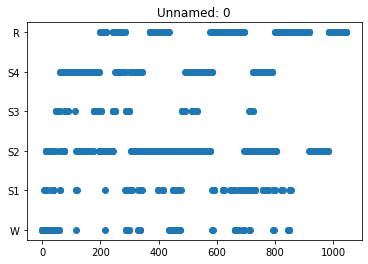

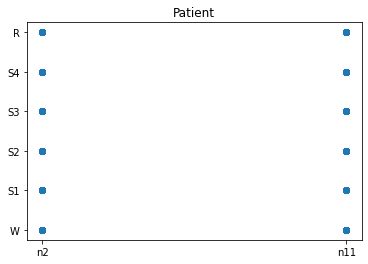

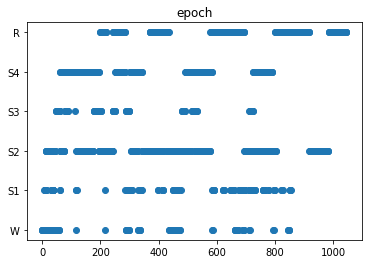

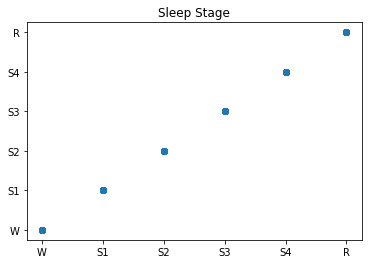

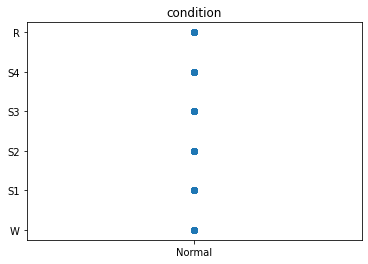

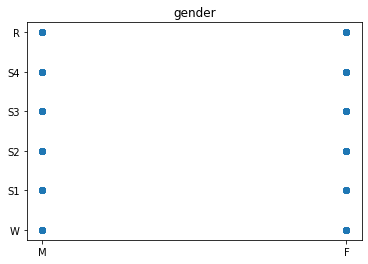

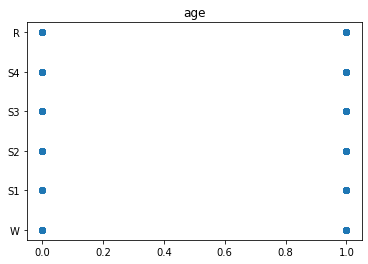

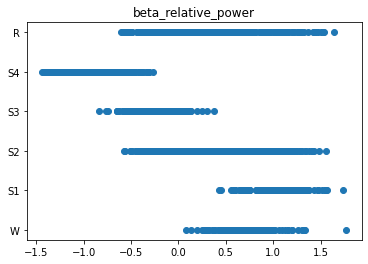

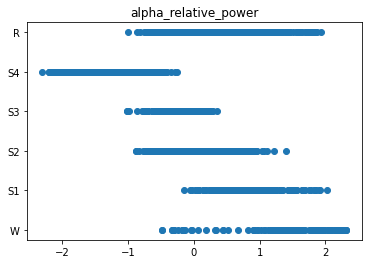

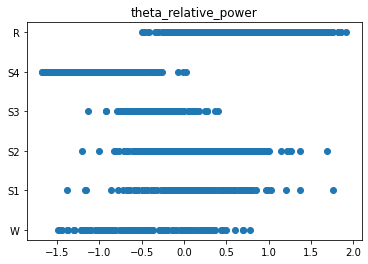

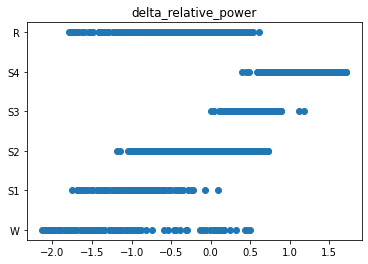

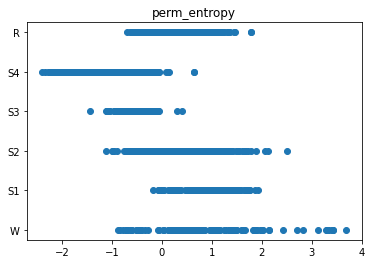

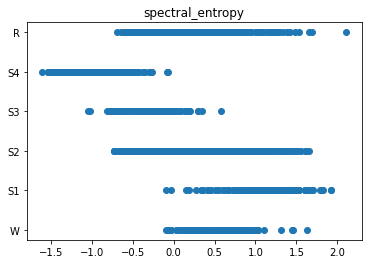

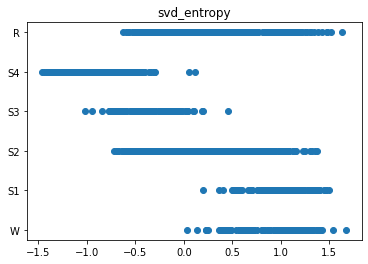

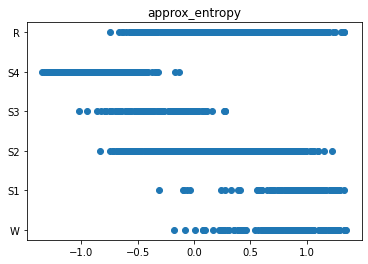

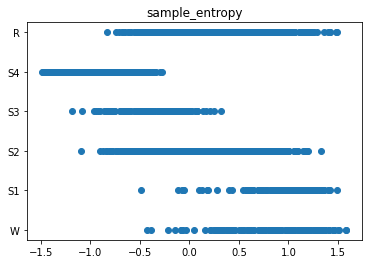

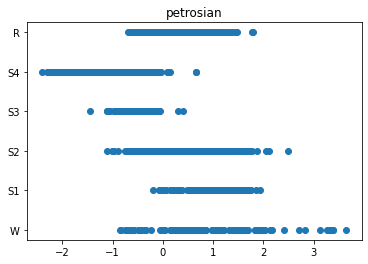

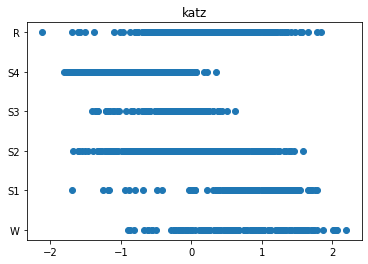

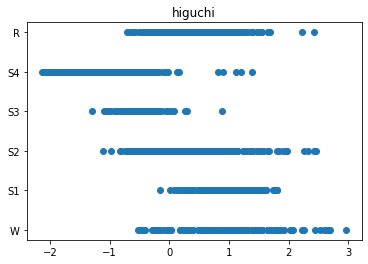

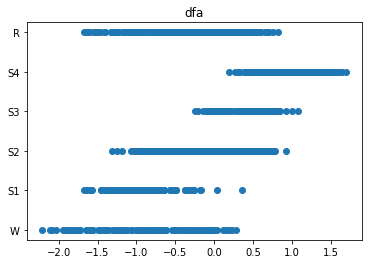

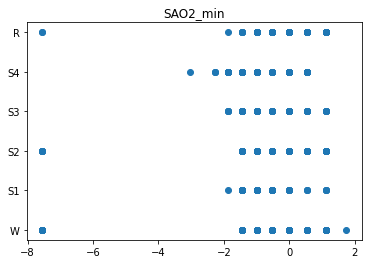

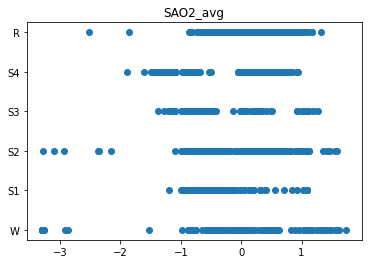

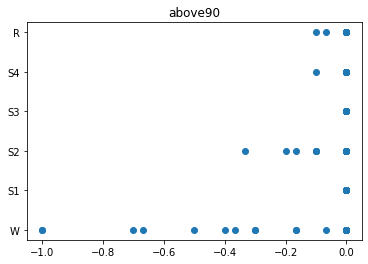

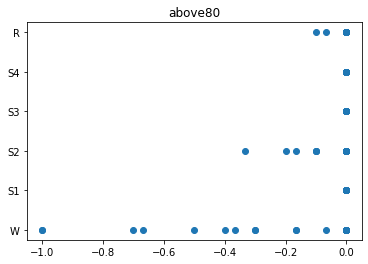

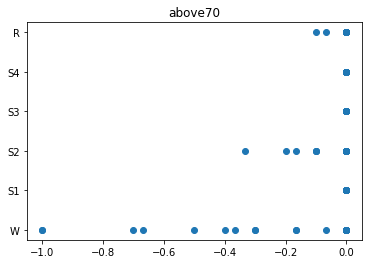

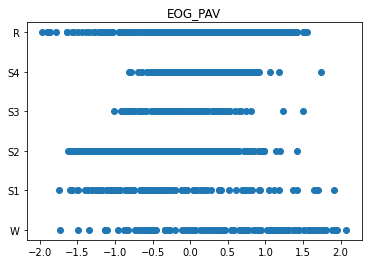

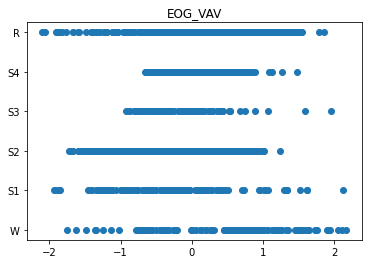

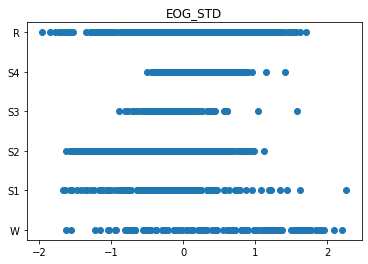

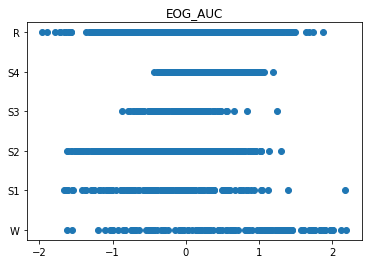

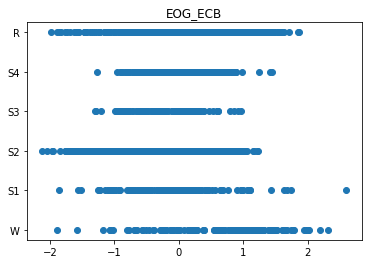

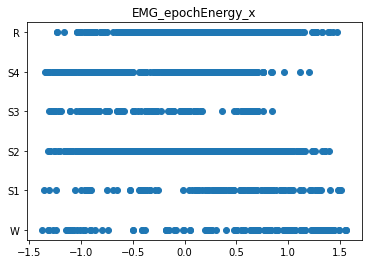

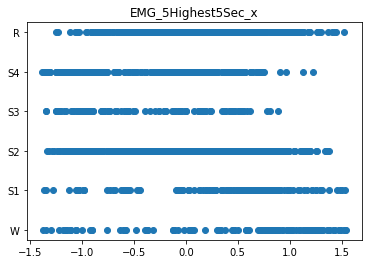

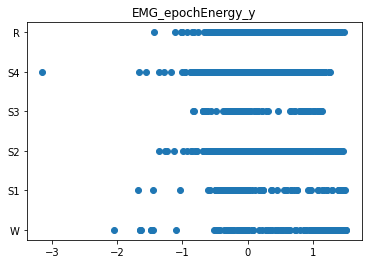

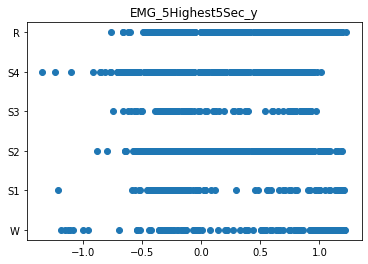

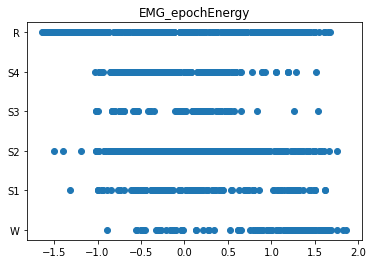

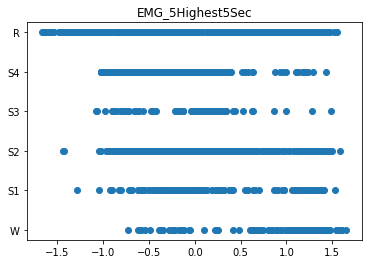

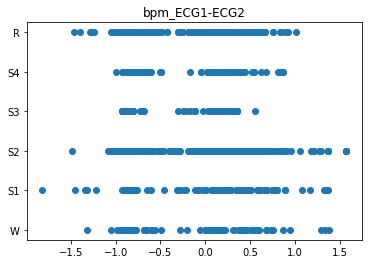

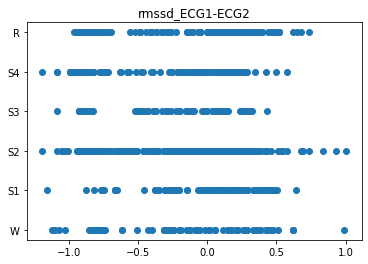

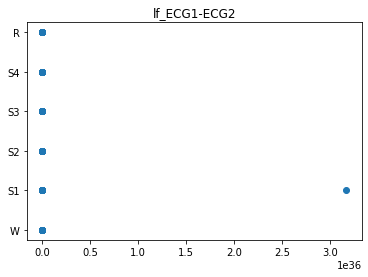

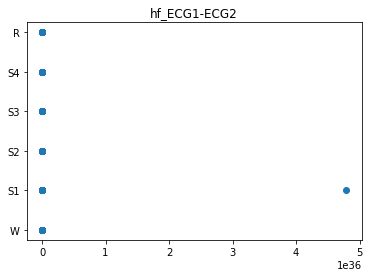

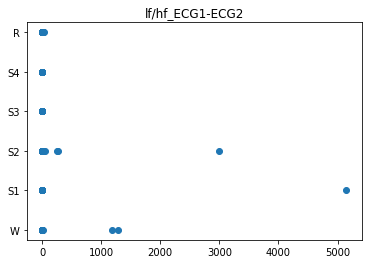

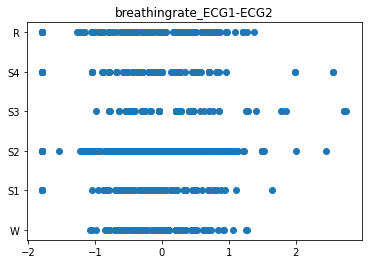

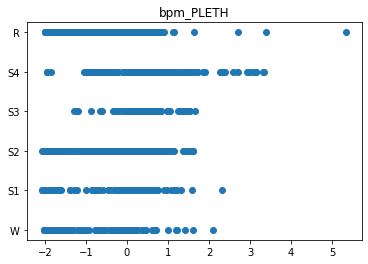

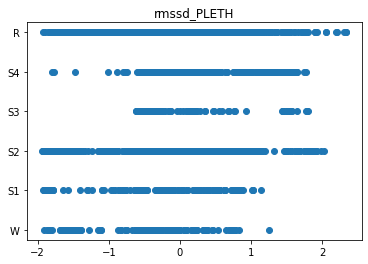

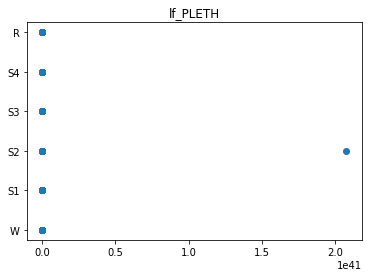

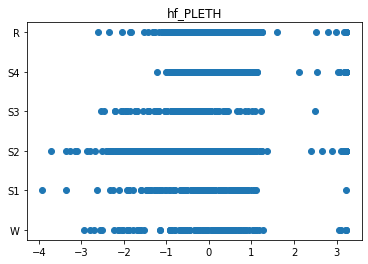

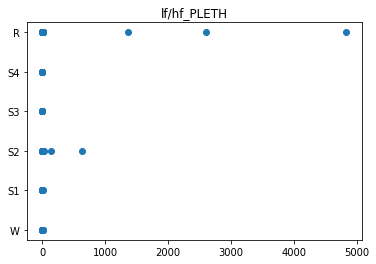

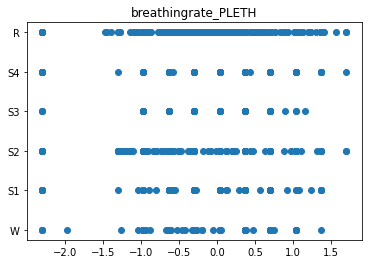

In [17]:
#allData = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15','plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6','rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17', 'ins2', 'ins6', 'n11', 'n2']
allData = ['n2', 'n11']
firstNumericCol = 6 # Includes age

final = pd.DataFrame()

for dataset in allData: # Stuff in the loop is done on each dataset individually before combining
    thisData = pd.read_csv(dataset+'.csv')
    column_names = thisData.columns[firstNumericCol - 1:]

    # Add a patient column based on the file name so can be used to do groupby operations
    thisData.insert(1, "Patient", dataset)

    # Truncate based on shortest column before NaN's:
    lastNonNaNEachCol = thisData.notna()[::-1].idxmax()
    thisData = thisData.truncate(after = min(lastNonNaNEachCol))
    
    # Fill in missing data using KNN
    impute_KNN = thisData.iloc[:, firstNumericCol:]
    imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
    thisData.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)

    # Combine with full dataset
    if final.empty:
        final = thisData
    else:
        final = pd.concat([final, thisData])
    
# Drop current "_norm" cols:
for col in final.columns:
    if "_norm" in col:
        final.drop(col, axis=1, inplace=True)

# Normalize (Divide by average within same patient):
for patient in final["Patient"].unique():
    thisPatientMeans = final[final["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    final[final["Patient"] == patient].iloc[:, firstNumericCol:] /= thisPatientMeans



# Sometimes outliers could be helpful (ex: EMG signal spikes during motion but is low otherwise.
# So the signal we want may be removed by a standard deviation or interquartile range-based outlier detection)
# Try density-based outlier detection (https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py)
    # Also, talk about this decision in PPT

# Remove outliers (Interquartile range method, upper fence and lower fence)
#outlierRows = []
#for column in final.columns[firstNumericCol:]:
#    print(column)
#    thisFeature = final[column]
#    quantiles = thisFeature.quantile([0.25, 0.5, 0.75])
#    first = quantiles[0]
#    median = quantiles[1]
#    third = quantiles[2]
#    interQuartileRange = third - first
#    upperFence = third + 1.5 * interQuartileRange
#    lowerFence = first - 1.5 * interQuartileRange
#    print(thisFeature)
    #outlierIndices = thisFeature[thisFeature < upperFence and thisFeature > lowerFence].index
#    print(outlierIndices)

    
#Box-Cox
for column in final.columns[firstNumericCol:]:
    try:
        final[column] = final[column].abs()
        box_cox_trans = stats.boxcox(final[column])[0]
        final[column] = box_cox_trans
    except:
        continue
    #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
    #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
print("Box-Cox completed.")  

#Robust Scaling
subset1 = final.iloc[:,:firstNumericCol]
subset2 = final.iloc[:,firstNumericCol:]

scaler = preprocessing.RobustScaler() # By default, centers and scales
robust_df = scaler.fit_transform(subset2)
final.iloc[:, firstNumericCol:] = robust_df
#robust_df = pd.DataFrame(robust_df, columns = column_names)
print("Robust Scaling completed.")


# Plot features #
fig = 0
for column in final.columns:
    plt.figure(fig)
    plt.scatter(final[column], final["Sleep Stage"])
    #plt.scatter(np.mean(final[column]), final['sleep_stage'], c = 'red')
    plt.title(column)
    fig += 1

# #Box-Cox
# for column in final.columns[firstNumericCol:]:
#     final[column] = final[column].abs()
#     box_cox_trans = stats.boxcox(final[column] + 1e-16)[0]
#     final[column] = box_cox_trans
#     #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
#     #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
# print("Box-Cox completed.")     

#Encoding (Sleep Stage)
final.drop("Unnamed: 0", axis=1, inplace=True)

final.insert(2, "sleep_stage", np.zeros(len(final)))

for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

final.drop("Sleep Stage", axis=1, inplace=True)

# Encoding (Condition)
conditionColumns = pd.DataFrame()
for patient in pd.unique(final['Patient']):
    thisPatientSeries = (final[final['Patient'] == patient])["condition"]
    thisPatientDf = thisPatientSeries.to_frame("condition")
    for condition in constants.CONDITION_TO_BINARY:
        if condition == thisPatientDf.at[0, 'condition']:
            binary = constants.CONDITION_TO_BINARY.get(condition)

            if binary[0] == 0:
                thisPatientDf.insert(1, "condition_0", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(1, "condition_0", np.ones(len(thisPatientDf)))

            if binary[1] == 0:
                thisPatientDf.insert(2, "condition_1", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(2, "condition_1", np.ones(len(thisPatientDf)))

            if binary[2] == 0:
                thisPatientDf.insert(3, "condition_2", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(3, "condition_2", np.ones(len(thisPatientDf)))

            if binary[3] == 0:
                thisPatientDf.insert(4, "condition_3", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(4, "condition_3", np.ones(len(thisPatientDf)))
    
    if conditionColumns.empty:
        conditionColumns = thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]
    else: # ConditionColumns already initialized
        conditionColumns = pd.concat([conditionColumns, thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]])
final.insert(5, "rbd", conditionColumns["condition_0"])
final.insert(6, "ins", conditionColumns["condition_1"])
final.insert(7, "nfle", conditionColumns["condition_2"])
final.insert(8, "plm", conditionColumns["condition_3"])

final.drop("condition", axis=1, inplace=True)

print('Encoding completed.')


#Robust Scaling
#subset1 = final.iloc[:,:firstNumericCol]
#subset2 = final.iloc[:,firstNumericCol:]

#scaler = preprocessing.RobustScaler() # By default, centers and scales
#robust_df = scaler.fit_transform(subset2)
#robust_df = pd.DataFrame(robust_df, columns = column_names)
#print("Robust Scaling done for " + dataset)

#Export
#final = pd.concat([subset1, robust_df], axis = 1)
final.reset_index(inplace=True)
final = final.iloc[:,1:]
final.to_csv('final.csv')
print('Dataset successfully exported!')

<ipython-input-18-02c527142de8>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(fig)


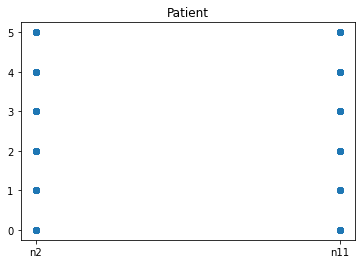

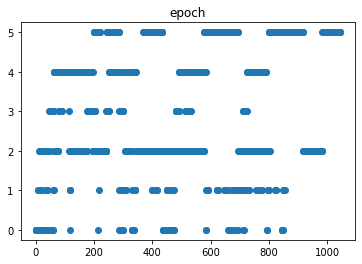

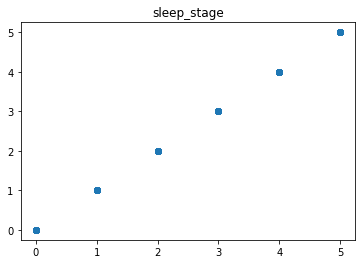

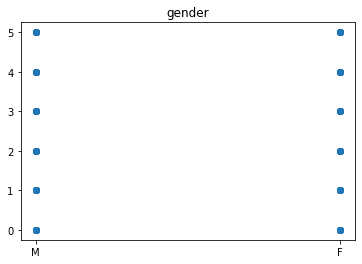

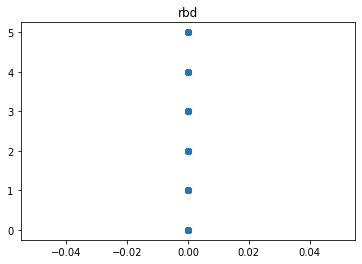

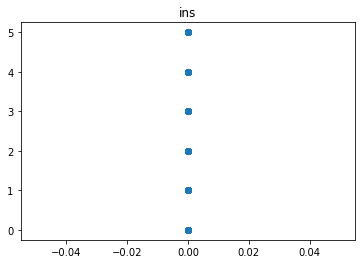

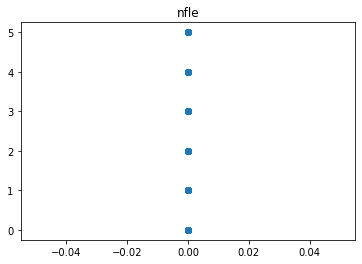

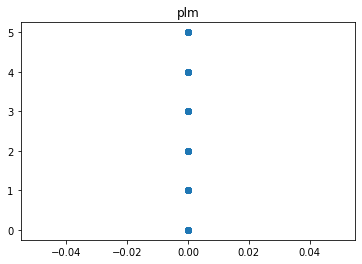

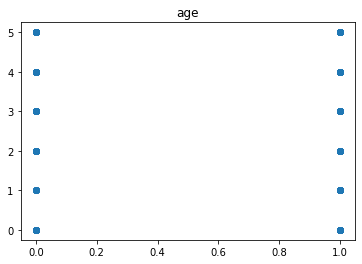

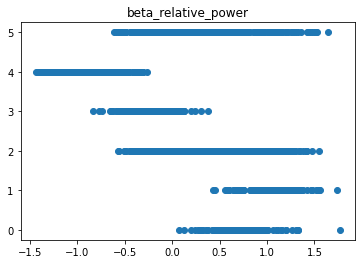

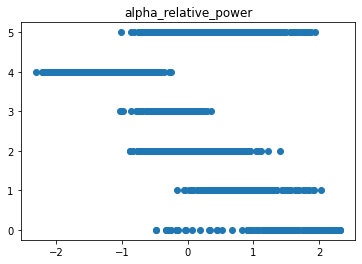

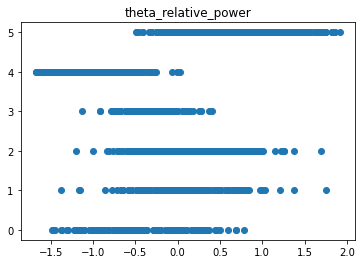

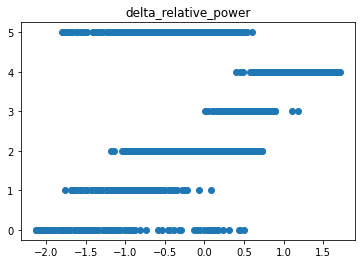

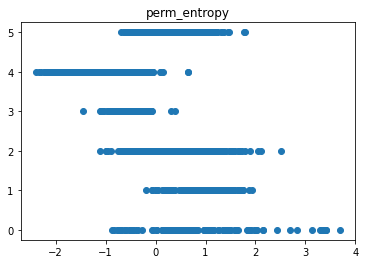

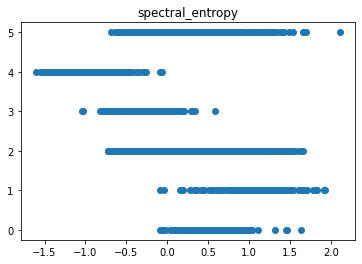

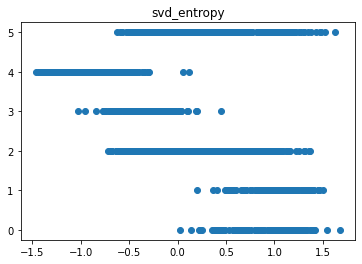

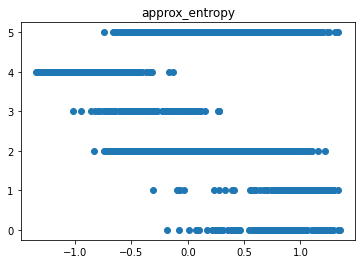

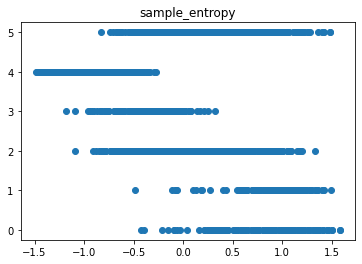

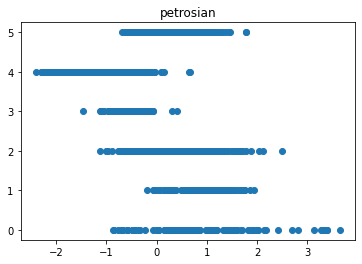

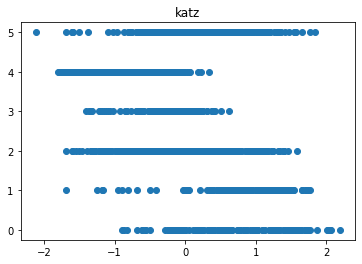

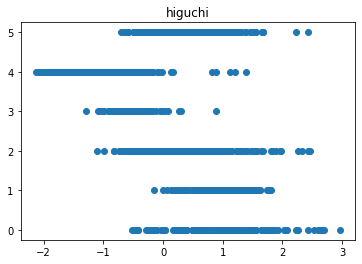

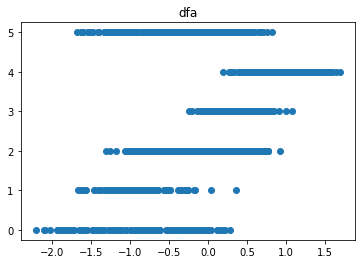

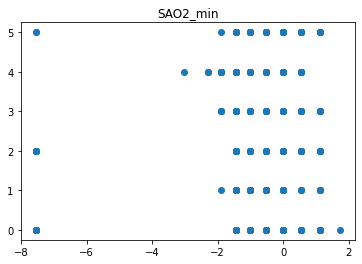

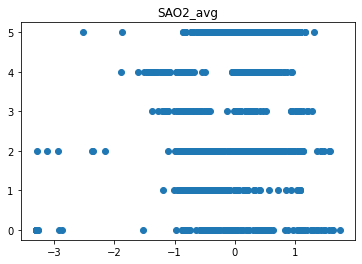

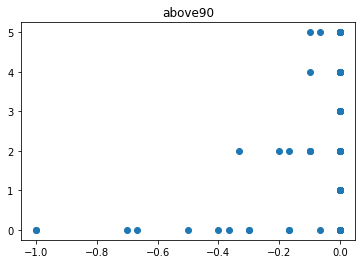

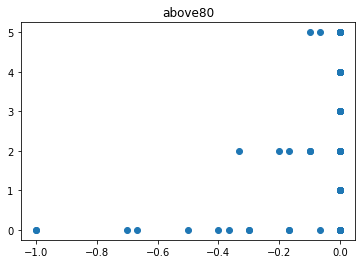

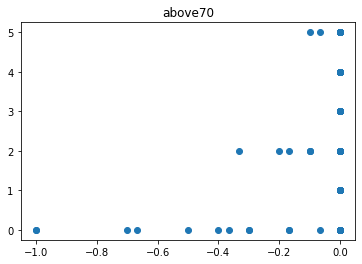

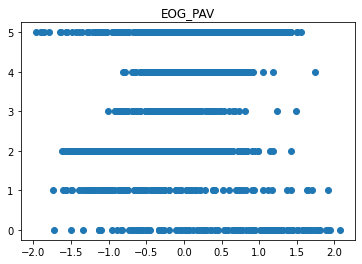

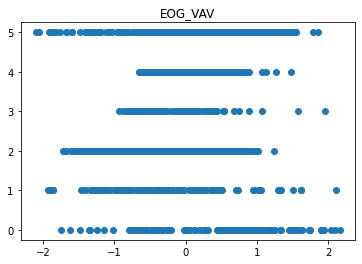

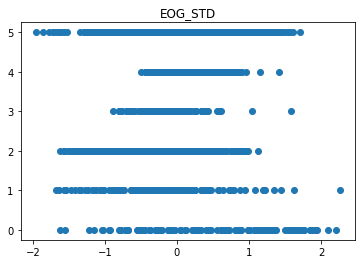

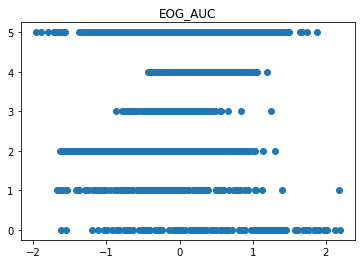

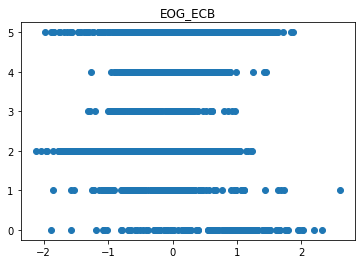

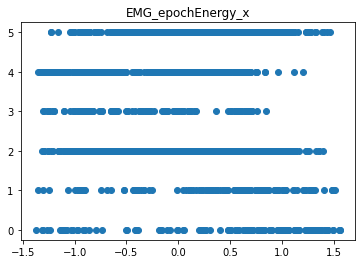

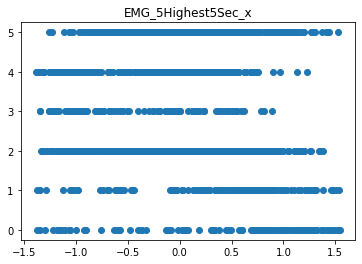

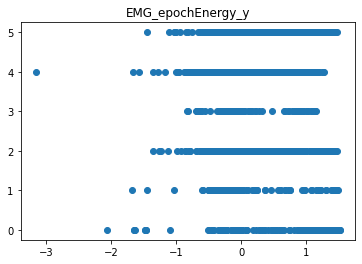

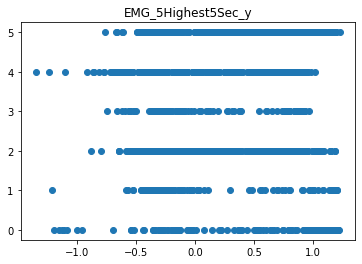

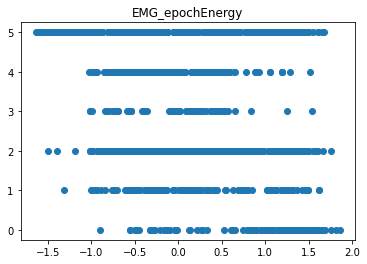

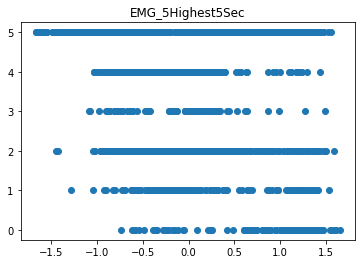

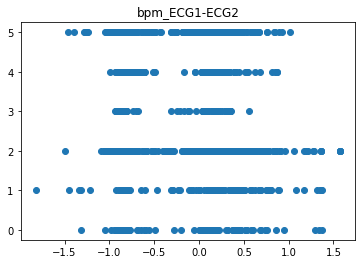

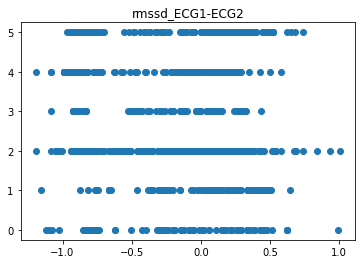

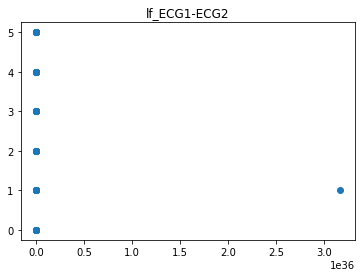

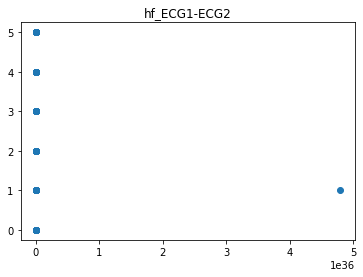

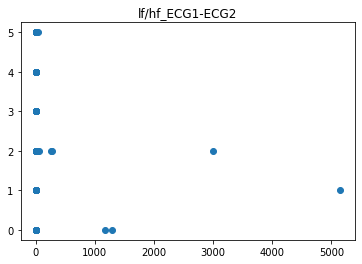

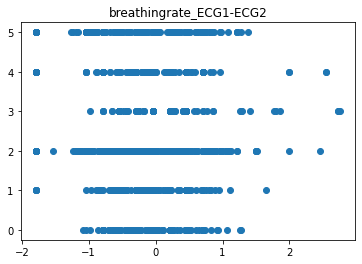

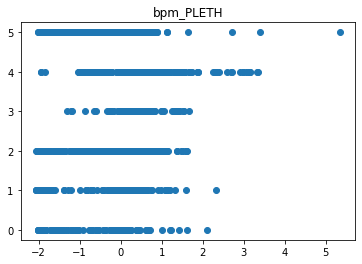

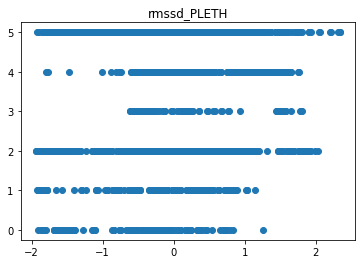

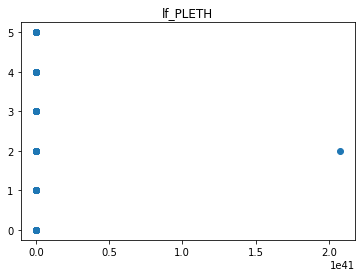

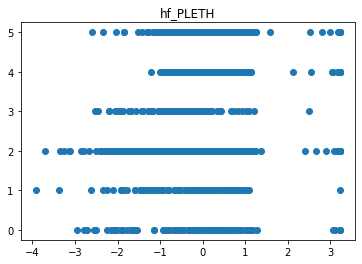

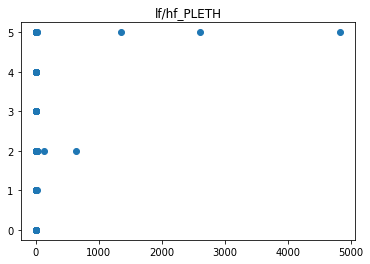

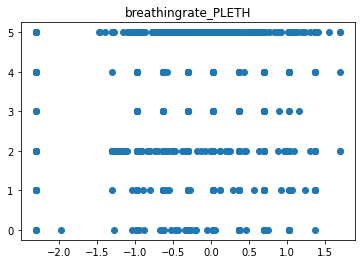

In [18]:
fig = 0
for column in final.columns:
    plt.figure(fig)
    plt.scatter(final[column], final["sleep_stage"])
    #plt.scatter(np.mean(final[column]), final['sleep_stage'], c = 'red')
    plt.title(column)
    fig += 1

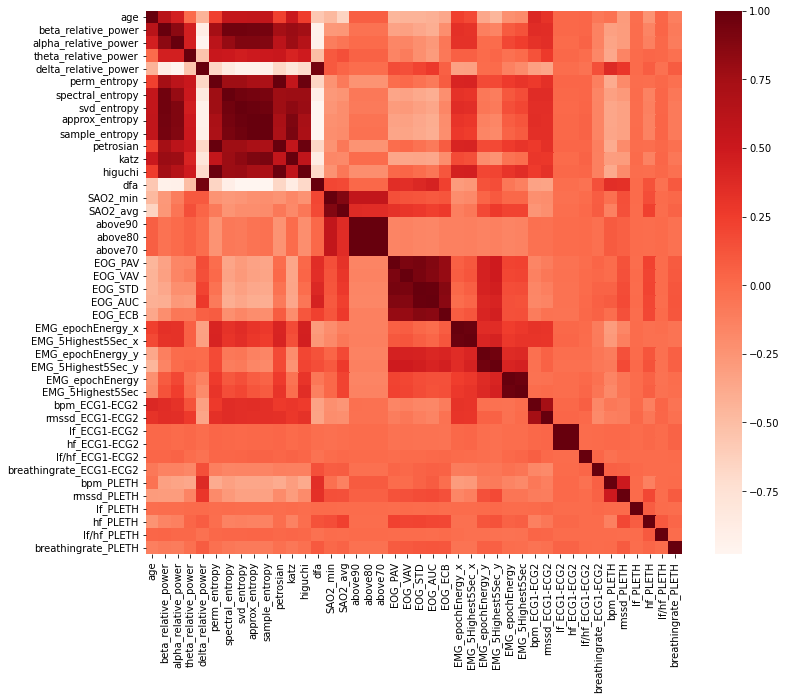

Empty DataFrame
Columns: [Feature A, Feature B, Corr]
Index: []
Threshold: 1
[]
Remaining Features: 50


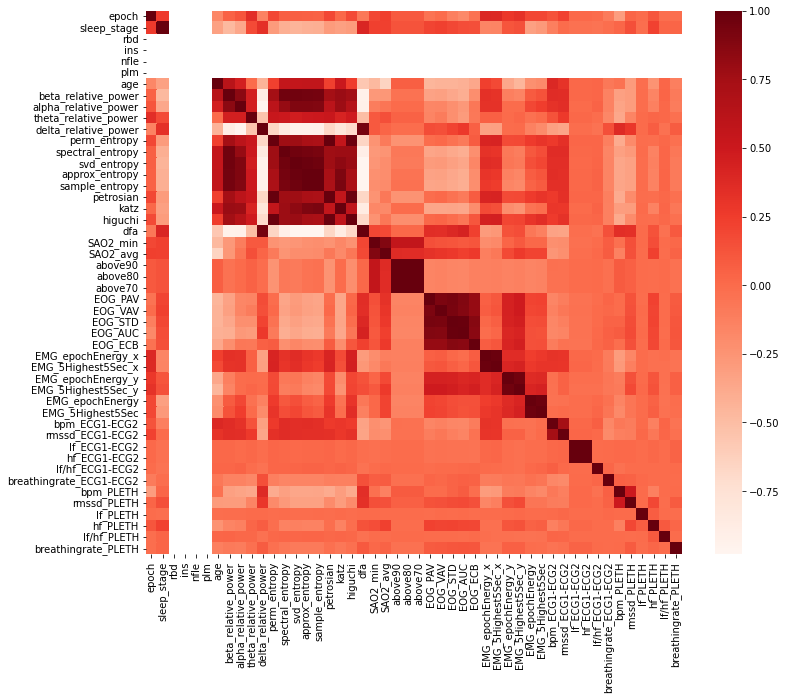

In [19]:
# Feature Removal Based on Between-Feature Correlation:

## INPUTS ##:
threshold = 0.8 # Abs correlation above which feature is removed

# 1. Calculate Correlation Matrix of the Predictors
columnsToCorr = list(final.columns)
safeFeatures = ['Patient', 'epoch', 'sleep_stage', 'rbd', 'ins', 'nfle', 'plm'] # Features that we won't remove
for i in safeFeatures:
    columnsToCorr.remove(i)

plt.figure(figsize=(12,10))
cor = final[columnsToCorr].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

# 2. Determine the two predictors associated with the largest absolute pairwise correlation
# Remove (set = 0) half of the matrix because symmetric:
lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask
corLowerTriangle = cor.where(lowerTriangleMask)
corAbs = corLowerTriangle.abs() # Consider absolute correlation

# Build sorted dataframe of form: ["Feature A", "Feature B", corr]
pairwiseCorr = corAbs.stack().reset_index()
pairwiseCorr.columns = ['Feature A','Feature B','Corr']

# Isolate correlations to remove
pairwiseCorr = pairwiseCorr[pairwiseCorr['Corr'] > threshold]
pairwiseCorr.sort_values('Corr', ascending = False, inplace = True)
print(pairwiseCorr)

# 3. Determine the average correlation between A and B and every other feature:
# Create an average correlation dataframe of form [feature, averageCorr]
averageCorr = pd.DataFrame(cor.abs().mean(axis = 1), cor.index, ['avgCorr'])

# Loop through pairwiseCorr, make a list of features to remove. 
featuresToRemove = []
for index, row in pairwiseCorr.iterrows():
    featureA = row['Feature A']
    featureB = row['Feature B']
    featureA_avgCorr = averageCorr.loc[featureA, 'avgCorr']
    featureB_avgCorr = averageCorr.loc[featureB, 'avgCorr']

    # If A has larger average correlation, remove it. Otherwise, remove B
    if featureA_avgCorr >= featureB_avgCorr:
        if featureA not in featuresToRemove:
            featuresToRemove.append(featureA)
    else:
        if featureB not in featuresToRemove:
            featuresToRemove.append(featureB)

# Report results:
print("Threshold: " + str(threshold))
print(featuresToRemove)

# Dataset with features removed
correlationFeatureRemoval = final.drop(featuresToRemove, axis = 1)
print("Remaining Features: " + str(correlationFeatureRemoval.shape[1]))

# Show the correlation matrix after feature removal
plt.figure(figsize=(12,10))
cor2 = correlationFeatureRemoval.corr()
sns.heatmap(cor2, annot=False, cmap=plt.cm.Reds)
plt.show()
    

In [5]:
print(averageCorr)
print(averageCorr.loc["above70", "avgCorr"])

                          avgCorr
age                      0.135883
beta_relative_power      0.289870
alpha_relative_power     0.204048
theta_relative_power     0.176014
delta_relative_power     0.267096
perm_entropy             0.327339
spectral_entropy         0.290230
svd_entropy              0.304706
approx_entropy           0.297450
sample_entropy           0.293552
petrosian                0.328004
katz                     0.261537
higuchi                  0.335233
dfa                      0.287483
SAO2_min                 0.198309
SAO2_avg                 0.173976
above90                  0.159852
above80                  0.170972
above70                  0.170654
EOG_PAV                  0.252999
EOG_VAV                  0.253700
EOG_STD                  0.260186
EOG_AUC                  0.260248
EOG_ECB                  0.224773
EMG_epochEnergy_x        0.152886
EMG_5Highest5Sec_x       0.163078
EMG_epochEnergy_y        0.255141
EMG_5Highest5Sec_y       0.241346
EMG_epochEnerg

In [20]:
# Feature Selection with Mutual Information

info_selection = pd.concat([correlationFeatureRemoval['sleep_stage'], correlationFeatureRemoval.iloc[:, 9:]], axis=1)

safe_features = list(correlationFeatureRemoval.iloc[:, :9].columns)

info_scores = []

for x in info_selection.columns[1:]:
    score = metrics.normalized_mutual_info_score(info_selection['sleep_stage'], info_selection[x])
    column_and_score = (x, score)
    info_scores.append(column_and_score)
    
target_columnscore = pd.DataFrame(info_scores).sort_values(by=1, ascending = False)

top_5_cols = safe_features+list(target_columnscore[0][:5])
top_10_cols = safe_features+list(target_columnscore[0][:10])
top_20_cols = safe_features+list(target_columnscore[0][:20])
top_30_cols = safe_features+list(target_columnscore[0][:30])

top_5_data = correlationFeatureRemoval[top_5_cols]
top_10_data = correlationFeatureRemoval[top_10_cols]
top_20_data = correlationFeatureRemoval[top_20_cols]
top_30_data = correlationFeatureRemoval[top_30_cols]

print(target_columnscore)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discr

                          0         1
30          rmssd_ECG1-ECG2  0.349241
36              rmssd_PLETH  0.348588
29            bpm_ECG1-ECG2  0.348533
6               svd_entropy  0.348431
0       beta_relative_power  0.348431
1      alpha_relative_power  0.348431
38                 hf_PLETH  0.348431
28         EMG_5Highest5Sec  0.348431
27          EMG_epochEnergy  0.348431
26       EMG_5Highest5Sec_y  0.348431
25        EMG_epochEnergy_y  0.348431
24       EMG_5Highest5Sec_x  0.348431
23        EMG_epochEnergy_x  0.348431
22                  EOG_ECB  0.348431
21                  EOG_AUC  0.348431
20                  EOG_STD  0.348431
7            approx_entropy  0.348431
11                  higuchi  0.348431
4              perm_entropy  0.348431
5          spectral_entropy  0.348431
2      theta_relative_power  0.348431
8            sample_entropy  0.348431
10                     katz  0.348431
9                 petrosian  0.348431
12                      dfa  0.348431
3      delta

In [7]:
display(top_30_data)

,Patient,epoch,sleep_stage,gender,rbd,ins,nfle,plm,age,EMG_epochEnergy_x,...,lf_PLETH,rmssd_ECG1-ECG2,bpm_ECG1-ECG2,hf_ECG1-ECG2,lf/hf_ECG1-ECG2,breathingrate_ECG1-ECG2,SAO2_avg,breathingrate_PLETH,above70,above90
0,nfle10,0,0.0,M,0.0,0.0,1.0,0.0,-1.134725,1.140039,...,-0.227958,-0.219280,0.601646,-0.098646,0.534896,0.000000,0.524577,-0.333333,0.000000,0.000000
1,nfle10,1,0.0,M,0.0,0.0,1.0,0.0,-1.134725,27.873629,...,-0.432330,-0.230317,0.740318,1.158502,-0.497174,-0.116530,-1.803012,-0.333333,-0.100000,-0.100000
2,nfle10,2,0.0,M,0.0,0.0,1.0,0.0,-1.134725,32.062216,...,-0.468621,1.013132,0.509471,0.249004,-0.497174,-1.127061,-0.366685,-1.000000,-0.033333,-0.033333
3,nfle10,3,0.0,M,0.0,0.0,1.0,0.0,-1.134725,1.554559,...,-0.436608,1.095134,0.138228,4.182769,-0.497174,0.127297,0.477806,-1.000000,0.000000,0.000000
4,nfle10,4,0.0,M,0.0,0.0,1.0,0.0,-1.134725,-0.005157,...,-0.232429,0.931130,0.144719,3.955175,-0.405379,-0.385345,0.595684,0.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19632,n2,850,1.0,M,0.0,0.0,0.0,0.0,-0.667102,0.732939,...,-0.683664,0.896192,0.951750,0.604727,0.445354,0.860988,0.218439,-0.333333,0.000000,0.000000
19633,n2,851,1.0,M,0.0,0.0,0.0,0.0,-0.667102,0.041841,...,-0.637873,0.922696,0.448423,0.207904,-0.497174,-1.124436,-0.066092,0.000000,0.000000,0.000000
19634,n2,852,1.0,M,0.0,0.0,0.0,0.0,-0.667102,0.010837,...,-0.707998,0.841156,0.488106,0.244808,-0.497174,-1.080671,-0.292437,-0.666667,0.000000,0.000000
19635,n2,853,1.0,M,0.0,0.0,0.0,0.0,-0.667102,0.005684,...,-0.740133,0.841156,0.537163,0.867966,-0.497174,-0.847891,-0.513473,0.000000,0.000000,0.000000


In [21]:
from sklearn.decomposition import PCA

firstColForPCA = 4

pca = PCA(n_components = 0.99, svd_solver = 'full')

principalComponents = pca.fit_transform(top_30_data.iloc[:, firstColForPCA:])
principalComponents = pd.DataFrame(principalComponents)

print(principalComponents.quantile([0.25, 0.5, 0.75]))
print(principalComponents.mean(axis = 0))
print(principalComponents.std(axis = 0))

display(principalComponents)

plt.scatter(principalComponents.iloc[:, 0], principalComponents.iloc[:, 1])

                 0
0.25 -1.093268e+38
0.50 -1.093268e+38
0.75 -1.093268e+38
0   -7.122551e+22
dtype: float64
0    4.765757e+39
dtype: float64


,0
0,-1.093268e+38
1,-1.093268e+38
2,-1.093268e+38
3,-1.093268e+38
4,-1.093268e+38
...,...
1896,-1.093268e+38
1897,-1.093268e+38
1898,-1.093268e+38
1899,-1.093268e+38


IndexError: single positional indexer is out-of-bounds